In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


[0]	validation_0-rmse:4.74760	validation_1-rmse:4.63607
[93]	validation_0-rmse:1.41091	validation_1-rmse:1.79125

📊 Validation Results:
MAE: 25,558,696.30
RMSE: 85,075,219.16
Custom ±10M Accuracy: 84.86%

📊 Test Results:
MAE: 24,742,834.17
RMSE: 69,474,925.51
Custom ±10M Accuracy: 85.12%


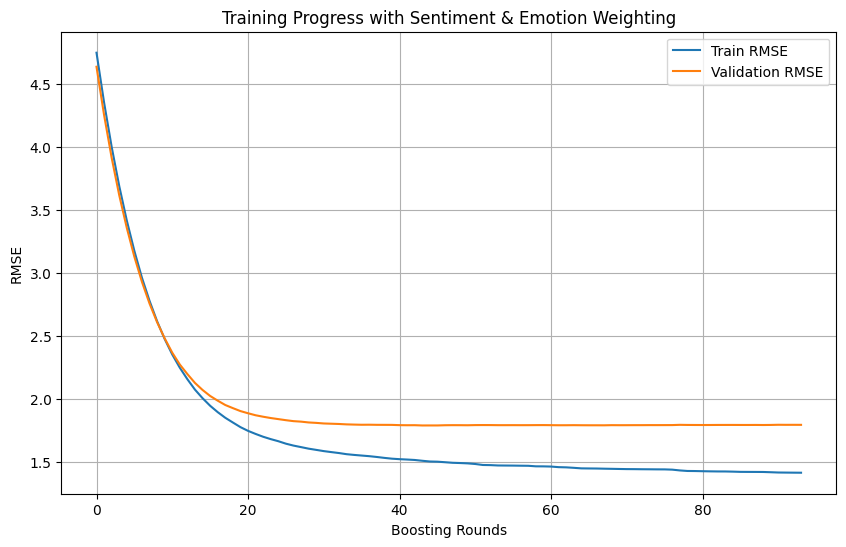

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# === 1. Loading enriched dataset ===
df = pd.read_csv('/content/drive/My Drive/cleaned_movies_with_sentiment.csv')

# === 2. Converting release_date column to datetime format ===
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# === 3. Performing feature engineering ===
df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month
df['cast_count'] = df['top_cast'].fillna('').str.split(', ').apply(len)
df['genre_count'] = df['genres'].fillna('').str.split(', ').apply(len)
df['keyword_count'] = df['keywords'].fillna('').str.split(', ').apply(len)

# Extracting top 50 directors and encoding others as 'other'
top_directors = df['director'].value_counts().nlargest(50).index
df['director_clean'] = df['director'].apply(lambda x: x if x in top_directors else 'other')

# Extracting top 50 production companies and encoding others as 'other'
df['main_prod_company'] = df['production_companies'].str.split(', ').str[0]
top_companies = df['main_prod_company'].value_counts().nlargest(50).index
df['main_prod_company'] = df['main_prod_company'].apply(lambda x: x if x in top_companies else 'other')

# Applying log transformation to the revenue column
df['log_revenue'] = np.log1p(df['revenue'])

# === 4. Applying one-hot encoding to categorical features ===
categorical_cols = ['language', 'status', 'main_prod_company', 'director_clean']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# === 5. Defining features and giving more weight to sentiment/emotion columns ===
sentiment_emotion_cols = [
    'very_negative', 'neutral', 'very_positive',
    'anger', 'disgust', 'joy', 'sadness'
]

# Giving more weight (×3) to these columns
for col in sentiment_emotion_cols:
    df[col] = df[col] * 3

drop_cols = ['movie_id', 'imdb_id', 'title', 'revenue', 'release_date',
             'genres', 'top_cast', 'keywords', 'production_companies',
             'director', 'genres_list', 'top_cast_list', 'keywords_list']

features = [col for col in df.columns if col not in drop_cols + ['log_revenue']]
X = df[features]
y = df['log_revenue']

# === 6. Splitting dataset ===
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.15, random_state=42)

# === 7. Initializing the XGBoost model ===
model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    eval_metric='rmse',
    early_stopping_rounds=50
)

# === 8. Training ===
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=100
)

# === 9. Evaluation ===
def evaluate(model, X, y_true, label):
    y_pred = model.predict(X)
    y_pred_rev = np.expm1(y_pred)
    y_true_rev = np.expm1(y_true)

    mae = mean_absolute_error(y_true_rev, y_pred_rev)
    rmse = np.sqrt(mean_squared_error(y_true_rev, y_pred_rev))
    within_range = np.abs(y_pred_rev - y_true_rev) <= 10000000
    custom_acc = np.mean(within_range)

    print(f"\n📊 {label} Results:")
    print(f"MAE: {mae:,.2f}")
    print(f"RMSE: {rmse:,.2f}")
    print(f"Custom ±10M Accuracy: {custom_acc * 100:.2f}%")

# === 10. Training Curve ===
def plot_training_progress(model):
    evals_result = model.evals_result()
    plt.figure(figsize=(10, 6))
    plt.plot(evals_result['validation_0']['rmse'], label='Train RMSE')
    plt.plot(evals_result['validation_1']['rmse'], label='Validation RMSE')
    plt.xlabel('Boosting Rounds')
    plt.ylabel('RMSE')
    plt.title('Training Progress with Sentiment & Emotion Weighting')
    plt.legend()
    plt.grid(True)
    plt.show()

# === 11. Evaluation ===
evaluate(model, X_val, y_val, "Validation")
evaluate(model, X_test, y_test, "Test")

# === 12. Plotting ===
plot_training_progress(model)
